## Соревнование "Шоколад"

## Описание данных

*   Company - компания производитель
*   Specific Bean Origin - географический регион происхождения
*   REF - параметр, определяющий момент внесения записи в базу данных (чем выше *   значение, тем "свежее" запись)
*   Review - дата публикации отзыва
*   Cocoa Percent - процентное содержание какао
*   Company Location - страна производитель
*   Rating - экспертный рейтинг (целевая переменная)
*   Bean Type - используемый сорт какао-бобов, если таковой имеется
*   Broad Bean Origin - географический регион происхождения какао-бобов

В датасете содержится информация о более чем 1700 шоколадках. В датасете представлена информация о темном шоколаде.

Система рейтинга шоколада:

*   5 = Elite
*   4 = Premium
*   3 = Satisfactory(3.0) to praiseworthy(3.75)
*   2 = Disappointing
*   1 = Unpleasant

Для получения рейтинга каждой шоколадки оцениваются все ее характеристики.

**По характеристикам шоколадки необходимо научиться предсказывать ее рейтинг без округлений** (то есть если рейтинг 3.75 - хорошая модель должна предсказать 3.75).

Рейтинги были собраны Brady Brelinski, Founding Member of the Manhattan Chocolate Society.

## Импорт библиотек, загрузка данных

In [1]:
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.0 MB/s eta 0:00:00


In [2]:
!pip install lightgbm -q

In [3]:
!pip install category_encoders -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 5.6 MB/s eta 0:00:00


In [4]:
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.5 MB/s eta 0:00:00


In [5]:
!pip install association-metrics

  Preparing metadata (setup.py) ... done
  Created wheel for association-metrics: filename=association_metrics-0.0.1-py3-none-any.whl size=3929 sha256=a67790bd87dfb93fc9a6d458cf692dc1f6775d602f644b6ee132ac4cd06b8de3
  Stored in directory: /root/.cache/pip/wheels/01/47/5f/4360ef6988df6f1b0c1857cab43334269110160bd97b716936
Successfully built association-metrics


In [6]:
import pandas as pd
import numpy as np
import association_metrics as am
import seaborn as sb
import matplotlib.pyplot as plt
import optuna
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import StackingRegressor


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [7]:
TRAIN = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_train.csv"
TEST = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_test_new.csv"

In [8]:
train_df = pd.read_csv(TRAIN)

## Обзор и обработка данных

In [9]:
train_df.head(20)

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia
5,Pitch Dark,Chuno,1510,2015,80%,U.S.A.,2.75,"Criollo, Trinitario",Nicaragua
6,Letterpress,Beniamo,1562,2015,70%,U.S.A.,3.25,,Bolivia
7,Shark Mountain,Cuyagua,1466,2015,77%,U.S.A.,2.75,Criollo,Venezuela
8,Laia aka Chat-Noir,"Lam Dong, Batch 153",1642,2015,75%,France,3.75,Trinitario,Vietnam
9,Duffy's,Star of Ecuador,523,2010,70%,U.K.,2.50,,Ecuador


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1255 non-null   object 
 1   Specific Bean Origin  1255 non-null   object 
 2   REF                   1255 non-null   int64  
 3   Review                1255 non-null   int64  
 4   Cocoa Percent         1255 non-null   object 
 5   Company Location      1255 non-null   object 
 6   Rating                1255 non-null   float64
 7   Bean Type             1254 non-null   object 
 8   Broad Bean Origin     1254 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 88.4+ KB


Заметим, что пропуски обозначаются пробелом. Заменим пропуски, чтобы с ними было удобно работать.

In [11]:
train_df = train_df.replace("\xa0", np.NAN)

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1255 non-null   object 
 1   Specific Bean Origin  1255 non-null   object 
 2   REF                   1255 non-null   int64  
 3   Review                1255 non-null   int64  
 4   Cocoa Percent         1255 non-null   object 
 5   Company Location      1255 non-null   object 
 6   Rating                1255 non-null   float64
 7   Bean Type             626 non-null    object 
 8   Broad Bean Origin     1199 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 88.4+ KB


Так как колонки REF и Review несут в себе одну и ту же информацию, удалим колонку "Review", как менее информативную.

In [13]:
del train_df["Review"]

Посмотрим на V-меру Крамера категориальных признаков

In [14]:
df_cat = train_df.apply(
        lambda x: x.astype("category") if x.dtype == "object" else x)
cramersv = am.CramersV(df_cat)

cramersv.fit()

,Company,Specific Bean Origin,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
Company,1.000000,0.771074,0.631564,0.999651,0.699234,0.606780
Specific Bean Origin,0.771074,1.000000,0.772975,0.808500,0.945435,0.986510
Cocoa Percent,0.631564,0.772975,1.000000,0.243803,0.209584,0.273609
Company Location,0.999651,0.808500,0.243803,1.000000,0.335082,0.384231
Bean Type,0.699234,0.945435,0.209584,0.335082,1.000000,0.460058
Broad Bean Origin,0.606780,0.986510,0.273609,0.384231,0.460058,1.000000


Можно заметить, что Bean Type сильно связан с Specific Bean Origin. При этом в колонке Bean Type пропущено около половины значений. Удалим колонку Bean Type, так как она содержит много пропусков.


Также колонки Company Location и Company, очевидно, очень связаны. Но так как признаков в датасете немного, попробуем совместить два предиктора, вместо удаления одного из них.



In [15]:
del train_df["Bean Type"]

In [16]:
train_df["Company Location"] = train_df["Company"] + "_" + train_df["Company Location"]
del train_df["Company"]

Пропуски в колонке Broad Bean Origin заполним модой по столбцу, предварительно сгруппировав данные по колонке Specific Bean Origin.

In [17]:
def fill_broad_bean_missing(x):
    try:
        return x.fillna(x.mode()[0])
    except: #Если не получилось найти моду в группе, заполняем пропуск глобальной модой
        return x.fillna(train_df["Broad Bean Origin"].mode()[0])


In [18]:
train_df["Broad Bean Origin"] = train_df.groupby(["Specific Bean Origin"])["Broad Bean Origin"].transform(fill_broad_bean_missing)

Посмотрим на количество уникальных значений в каждом столбце

In [19]:
for col in train_df.columns:
    print(col, len(train_df[col].unique()))

Specific Bean Origin 762
REF 433
Cocoa Percent 40
Company Location 377
Rating 13
Broad Bean Origin 83


Так как категориальный признак Cocoa Percent имеет естественную числовую интерпретацию(например, 85% больше 75%), логично будет ее сохранить. Превратим категориальный признак Cocoa Percent в числовой, удалив значок % и поделив на 100. Остальные категориальные признаки придется кодировать хитрее.

In [20]:
train_df["Cocoa Percent"] = train_df["Cocoa Percent"].apply(lambda x: float(x.replace("%",""))/100)

In [21]:
train_df

,Specific Bean Origin,REF,Cocoa Percent,Company Location,Rating,Broad Bean Origin
0,Rio Caribe,457,0.72,Willie's Cacao_U.K.,3.25,Venezuela
1,"Ocumare, Premier Cru, Quizas No. 2",508,0.72,Beschle (Felchlin)_Switzerland,3.50,Venezuela
2,Tanzania,1554,0.70,Dark Forest_U.S.A.,3.00,Tanzania
3,Cooproagro,1125,0.72,Brasstown aka It's Chocolate_U.S.A.,3.00,Dominican Republic
4,"Java, Indonesie",32,0.75,Pralus_France,3.50,Indonesia
...,...,...,...,...,...,...
1250,Madagascar,363,0.80,Artisan du Chocolat_U.K.,3.00,Madagascar
1251,Cusco,1884,0.70,Marana_Peru,2.75,Peru
1252,Nacional,1534,0.68,Arete_U.S.A.,3.50,Peru
1253,"Conacado, #212, LR, SC",642,0.72,Fresco_U.S.A.,3.50,Dominican Republic


Посмотрим на гистограмму целевой переменной. Распределение напоминает нормальное, поэтому нет необходимости преобразовывать целевую переменную.

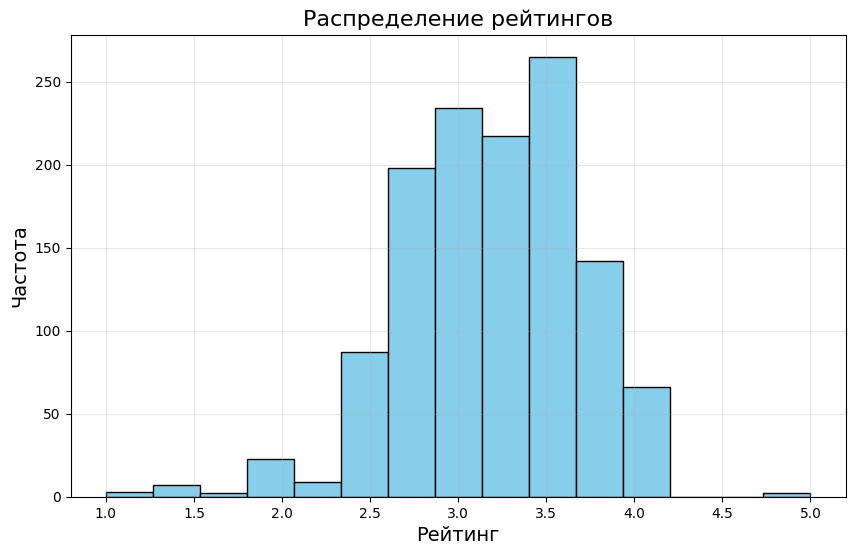

In [23]:

plt.figure(figsize=(10, 6))
plt.hist(train_df["Rating"], bins=15, color='skyblue', edgecolor='black')


plt.title("Распределение рейтингов", fontsize=16)
plt.xlabel("Рейтинг", fontsize=14)
plt.ylabel("Частота", fontsize=14)
plt.grid(True, alpha=0.3)


plt.show()

Исследуем числовые признаки на выбросы с помощью боксплота. В колонках Cocao Percent и Rating нашлись экстремальные значения, но при более детальном рассмотрении можно понять, что выбросами эти значения не являются. Удалять ничего не будем.

<Figure size 1200x800 with 0 Axes>

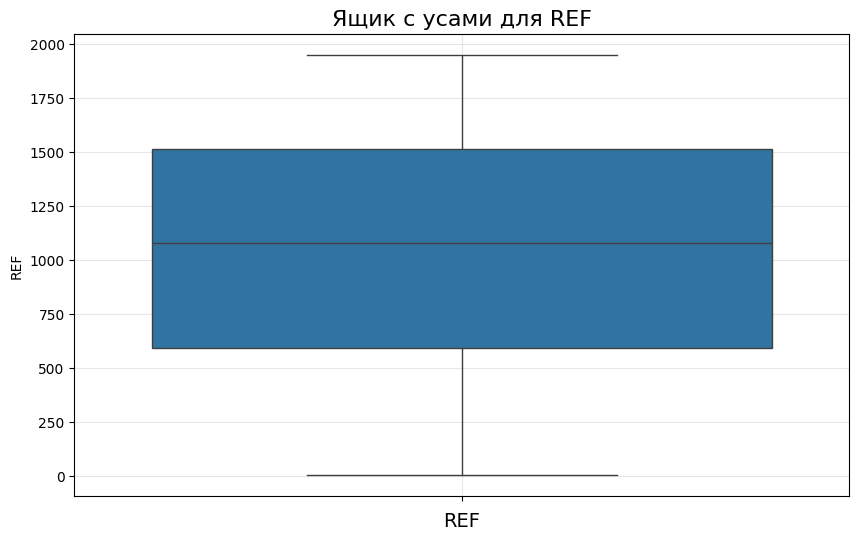

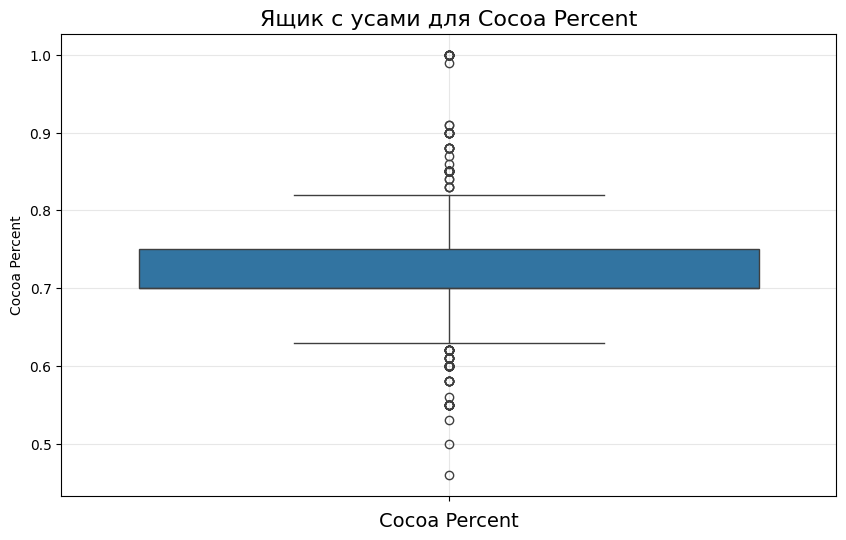

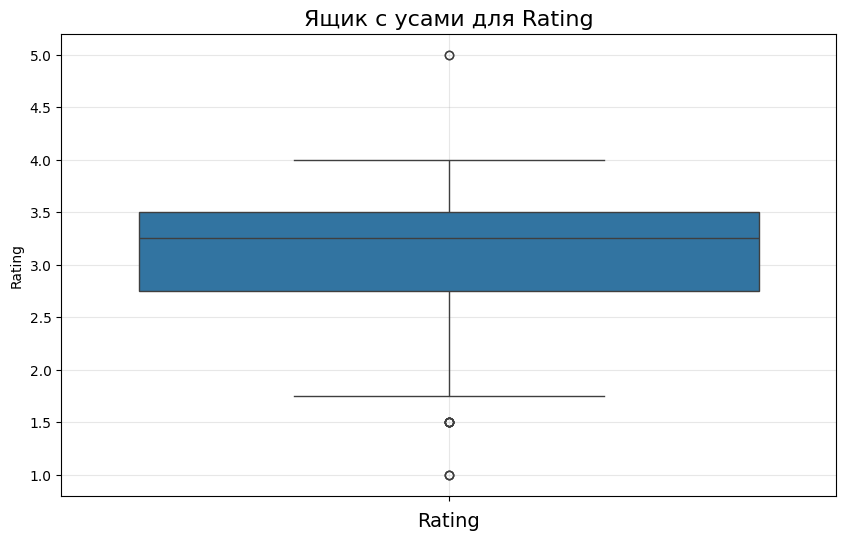

In [26]:
plt.figure(figsize=(12, 8))

for col in train_df.columns[train_df.dtypes != 'object']:
    plt.figure(figsize=(10, 6))
    sb.boxplot(train_df[col], fliersize=6)

    plt.title(f'Ящик с усами для {col}', fontsize=16)
    plt.xlabel(col, fontsize=14)
    plt.grid(True, alpha=0.3)

    plt.show()

## Построение baseline модели

Разобъем данные на тренировочную и тестовую части

In [ ]:
X = train_df.drop("Rating",axis = 1)
y = train_df["Rating"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

В качестве базовых моделей будем использовать RandomForestRegressor, CatBoostRegressor, LGBMRegressor.

Подберем оптимальные кодировщики и скалеры.

In [ ]:
p1 = Pipeline([
    ('encoder_',TargetEncoder(cols=["Company Location", "Specific Bean Origin", "Broad Bean Origin"])),
    ('scaler_', StandardScaler()),
    ('model_', RandomForestRegressor(n_jobs=-1))
    ])
p2 = Pipeline([
    ('encoder_',TargetEncoder(cols=["Company Location", "Specific Bean Origin", "Broad Bean Origin"], smoothing= 1)),
    ('scaler_', StandardScaler()),
    ('model_', RandomForestRegressor(n_jobs=-1))
    ])
p3 = Pipeline([
    ('encoder_',TargetEncoder(cols=["Company Location", "Specific Bean Origin", "Broad Bean Origin"] , smoothing= 100)),
    ('scaler_', StandardScaler()),
    ('model_', RandomForestRegressor(n_jobs=-1))
    ])
p4 = Pipeline([
    ('encoder_',TargetEncoder(cols=["Company Location", "Specific Bean Origin", "Broad Bean Origin"])),
    ('scaler_', MinMaxScaler()),
    ('model_', RandomForestRegressor(n_jobs=-1))
    ])
p5 = Pipeline([
    ('encoder_',TargetEncoder(cols=["Company Location", "Specific Bean Origin", "Broad Bean Origin"], smoothing= 1)),
    ('scaler_', MinMaxScaler()),
    ('model_', RandomForestRegressor(n_jobs=-1))
    ])
p6 = Pipeline([
    ('encoder_',TargetEncoder(cols=["Company Location", "Specific Bean Origin", "Broad Bean Origin"] , smoothing= 100)),
    ('scaler_', MinMaxScaler()),
    ('model_', RandomForestRegressor(n_jobs=-1))
    ])
p7 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=["Company Location", "Specific Bean Origin", "Broad Bean Origin"])),
    ('scaler_', StandardScaler()),
    ('model_', RandomForestRegressor(n_jobs=-1))
    ])
p8 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=["Company Location", "Specific Bean Origin", "Broad Bean Origin"])),
    ('scaler_', MinMaxScaler()),
    ('model_', RandomForestRegressor(n_jobs=-1))
    ])


p9 = Pipeline([
    ('encoder_',TargetEncoder(cols=["Company Location", "Specific Bean Origin", "Broad Bean Origin"])),
    ('scaler_', StandardScaler()),
    ('model_', CatBoostRegressor(verbose = 0))
    ])
p10 = Pipeline([
    ('encoder_',TargetEncoder(cols=["Company Location", "Specific Bean Origin", "Broad Bean Origin"], smoothing= 1)),
    ('scaler_', StandardScaler()),
    ('model_', CatBoostRegressor(verbose = 0))
    ])
p11 = Pipeline([
    ('encoder_',TargetEncoder(cols=["Company Location", "Specific Bean Origin", "Broad Bean Origin"] , smoothing= 100)),
    ('scaler_', StandardScaler()),
    ('model_', CatBoostRegressor(verbose = 0))
    ])
p12 = Pipeline([
    ('encoder_',TargetEncoder(cols=["Company Location", "Specific Bean Origin", "Broad Bean Origin"])),
    ('scaler_', MinMaxScaler()),
    ('model_',CatBoostRegressor(verbose = 0))
    ])
p13 = Pipeline([
    ('encoder_',TargetEncoder(cols=["Company Location", "Specific Bean Origin", "Broad Bean Origin"], smoothing= 1)),
    ('scaler_', MinMaxScaler()),
    ('model_', CatBoostRegressor(verbose = 0))
    ])
p14 = Pipeline([
    ('encoder_',TargetEncoder(cols=["Company Location", "Specific Bean Origin", "Broad Bean Origin"] , smoothing= 100)),
    ('scaler_', MinMaxScaler()),
    ('model_', CatBoostRegressor(verbose = 0))
    ])
p15 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=["Company Location", "Specific Bean Origin", "Broad Bean Origin"])),
    ('scaler_', StandardScaler()),
    ('model_', CatBoostRegressor(verbose = 0))
    ])
p16 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=["Company Location", "Specific Bean Origin", "Broad Bean Origin"])),
    ('scaler_', MinMaxScaler()),
    ('model_', CatBoostRegressor(verbose = 0))
    ])


p17 = Pipeline([
    ('encoder_',TargetEncoder(cols=["Company Location", "Specific Bean Origin", "Broad Bean Origin"])),
    ('scaler_', StandardScaler()),
    ('model_', LGBMRegressor())
    ])
p18= Pipeline([
    ('encoder_',TargetEncoder(cols=["Company Location", "Specific Bean Origin", "Broad Bean Origin"], smoothing= 1)),
    ('scaler_', StandardScaler()),
    ('model_', LGBMRegressor())
    ])
p19 = Pipeline([
    ('encoder_',TargetEncoder(cols=["Company Location", "Specific Bean Origin", "Broad Bean Origin"] , smoothing= 100)),
    ('scaler_', StandardScaler()),
    ('model_', LGBMRegressor())
    ])
p20 = Pipeline([
    ('encoder_',TargetEncoder(cols=["Company Location", "Specific Bean Origin", "Broad Bean Origin"])),
    ('scaler_', MinMaxScaler()),
    ('model_',LGBMRegressor())
    ])
p21 = Pipeline([
    ('encoder_',TargetEncoder(cols=["Company Location", "Specific Bean Origin", "Broad Bean Origin"], smoothing= 1)),
    ('scaler_', MinMaxScaler()),
    ('model_', LGBMRegressor())
    ])
p22 = Pipeline([
    ('encoder_',TargetEncoder(cols=["Company Location", "Specific Bean Origin", "Broad Bean Origin"] , smoothing= 100)),
    ('scaler_', MinMaxScaler()),
    ('model_', LGBMRegressor())
    ])
p23 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=["Company Location", "Specific Bean Origin", "Broad Bean Origin"])),
    ('scaler_', StandardScaler()),
    ('model_', LGBMRegressor())
    ])
p24 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=["Company Location", "Specific Bean Origin", "Broad Bean Origin"])),
    ('scaler_', MinMaxScaler()),
    ('model_',LGBMRegressor())
    ])

In [ ]:
for i,p in enumerate([p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,p21,p22,p23,p24]):
    print(i+1, cross_val_score(p, X, y, cv=3, scoring='r2', n_jobs=-1).mean())

Трудно сказать, какой кодировщик и скалер лучше. Выберем LeaveOneOut и StandartScaler.

Лучше всех себя показал CatBoost. Посмотрим, что будет, если дать ему самому закодировать категориальные признаки.

In [ ]:
cross_val_score(CatBoostRegressor(cat_features=[0,3,4]), X, y, cv=3, scoring='r2', n_jobs=-1).mean()

Получилось улучшить метрику.

Теперь посмотрим, что будет, если добавить полиномиальные признаки.

In [ ]:
p25 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=["Company Location", "Specific Bean Origin", "Broad Bean Origin"])),
    ('features', PolynomialFeatures()),
    ('scaler_', StandardScaler()),
    ('model_', RandomForestRegressor(n_jobs=-1))])
p26 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=["Company Location", "Specific Bean Origin", "Broad Bean Origin"])),
    ('features', PolynomialFeatures()),
    ('scaler_', StandardScaler()),
    ('model_', CatBoostRegressor(verbose = 0))])
p27 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=["Company Location", "Specific Bean Origin", "Broad Bean Origin"])),
    ('features', PolynomialFeatures()),
    ('scaler_', StandardScaler()),
    ('model_', LGBMRegressor())])

p28 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=["Company Location", "Specific Bean Origin", "Broad Bean Origin"])),
    ('features', PolynomialFeatures(degree = 3)),
    ('scaler_', StandardScaler()),
    ('model_', RandomForestRegressor(n_jobs=-1))])
p29 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=["Company Location", "Specific Bean Origin", "Broad Bean Origin"])),
    ('features', PolynomialFeatures(degree = 3)),
    ('scaler_', StandardScaler()),
    ('model_', CatBoostRegressor(verbose = 0))])
p30 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=["Company Location", "Specific Bean Origin", "Broad Bean Origin"])),
    ('features', PolynomialFeatures(degree = 3)),
    ('scaler_', StandardScaler()),
    ('model_', LGBMRegressor())])

In [ ]:
for i,p in enumerate([p25,p26,p27,p28,p29,p30]):
    print(i+25, cross_val_score(p, X, y, cv=3, scoring='r2', n_jobs=-1).mean())

Результат в среднем улучшился.

## Подбор гиперпараметров модели

Будем использовать LeaveOneOutEncoder, StadartScaler и PolynomialFeatures(degree = 3). CatBoost обучим без предварительной обработки данных.

Метрику качества будем вычислять по кросс-валидации.

Подберем гиперпараметры RandomForestRegressor

In [ ]:
data_pipeline = Pipeline([
        ('encoder_',LeaveOneOutEncoder(cols=["Company Location", "Specific Bean Origin", "Broad Bean Origin"])),
        ('features', PolynomialFeatures(degree = 3)),
        ('scaler_', StandardScaler())
])

X_train_good = data_pipeline.fit_transform(X_train, y_train)
X_test_good = data_pipeline.transform(X_test)

In [ ]:
def objective(trial):

    param = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1500, 50),
        "max_features": trial.suggest_float("max_features", 0.1, 1.),
        "criterion": trial.suggest_categorical('criterion', ['squared_error', 'absolute_error', 'friedman_mse', 'poisson']),
        "max_depth": trial.suggest_int("max_depth", 5, 50),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 21),
        "min_samples_leaf": trial.suggest_int('min_samples_leaf', 2, 21)
    }

    score = cross_val_score(RandomForestRegressor(**param, verbose=False, n_jobs=-1),
                            X_train_good, y_train, cv=3, scoring='r2', n_jobs=-1).mean()
    return score



study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)
print(study.best_trial)

In [ ]:
RF_model = RandomForestRegressor(**{'n_estimators': 1000, 'max_features': 0.6446291672999823, 'criterion': 'squared_error', 'max_depth': 30, 'min_samples_split': 20, 'min_samples_leaf': 20}).fit(X_train_good, y_train)
r2_score(y_test,RF_model.predict(X_test_good))

0.012688515838291115

In [ ]:
r2_score(y_train,RF_model.predict(X_train_good))

0.22314646432704177

Качество модели на тестовых данных получилось не очень хорошее, но модель не переобучилась. Видимо, она плохо предсказывает зависимость, а, может быть, ей не хватило выборки.

Теперь подберем гиперпараметры для CatBoostRegressor.

In [ ]:
def objective(trial):
    param = {
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        'l2_leaf_reg':trial.suggest_int('l2_leaf_reg',4,30),
        'learning_rate':trial.suggest_float('learning_rate', 0.001, 0.3),
        'random_strength': trial.suggest_float('random_strength', 1, 3),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.01, 0.5)
    }
    model = CatBoostRegressor(**param, early_stopping_rounds= 30, verbose=0, cat_features = [0,3,4])
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='r2', n_jobs=-1,).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)
print(study.best_trial)

[I 2024-07-03 18:43:26,337] A new study created in memory with name: no-name-b78d17f5-5012-411c-ab9c-e498da8c100b
[I 2024-07-03 18:43:32,494] Trial 0 finished with value: 0.1342850099548526 and parameters: {'max_depth': 4, 'n_estimators': 422, 'l2_leaf_reg': 18, 'learning_rate': 0.29502620202308677, 'random_strength': 2.484881344480849, 'bagging_temperature': 0.19940470299288646}. Best is trial 0 with value: 0.1342850099548526.
[I 2024-07-03 18:43:38,788] Trial 1 finished with value: 0.16910448909421041 and parameters: {'max_depth': 8, 'n_estimators': 455, 'l2_leaf_reg': 22, 'learning_rate': 0.11084550405540103, 'random_strength': 2.9682254939348, 'bagging_temperature': 0.2251435777230088}. Best is trial 1 with value: 0.16910448909421041.
[I 2024-07-03 18:43:40,805] Trial 2 finished with value: 0.11978075936103916 and parameters: {'max_depth': 9, 'n_estimators': 153, 'l2_leaf_reg': 7, 'learning_rate': 0.22087221568372978, 'random_strength': 1.3449576018320017, 'bagging_temperature': 0.

FrozenTrial(number=155, state=TrialState.COMPLETE, values=[0.19511251972325463], datetime_start=datetime.datetime(2024, 7, 3, 18, 59, 10, 274070), datetime_complete=datetime.datetime(2024, 7, 3, 18, 59, 15, 741300), params={'max_depth': 6, 'n_estimators': 809, 'l2_leaf_reg': 9, 'learning_rate': 0.019740703132738093, 'random_strength': 2.210649111513943, 'bagging_temperature': 0.02730216355143037}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=10, log=False, low=2, step=1), 'n_estimators': IntDistribution(high=1000, log=False, low=50, step=1), 'l2_leaf_reg': IntDistribution(high=30, log=False, low=4, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.001, step=None), 'random_strength': FloatDistribution(high=3.0, log=False, low=1.0, step=None), 'bagging_temperature': FloatDistribution(high=0.5, log=False, low=0.01, step=None)}, trial_id=155, value=None)


In [ ]:
CB_model = CatBoostRegressor(**{'max_depth': 6, 'n_estimators': 1000, 'l2_leaf_reg': 20, 'learning_rate': 0.019740703132738093, 'random_strength': 2.210649111513943, 'bagging_temperature': 0.02730216355143037},early_stopping_rounds= 30,verbose = 0).fit(X_train, y_train,cat_features = [0,3,4])
r2_score(y_test,CB_model.predict(X_test))

0.22214919898043395

In [ ]:
r2_score(y_train,CB_model.predict(X_train))

0.49187874415046573

Catboost справился лучше.

Теперь подберем гиперпараметры для LGBMRegressor.

In [ ]:
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'max_bin': trial.suggest_int('max_bin', 100, 260),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1, 100),
        'lambda_l2': trial.suggest_float('lambda_l2', 1, 100),
        'extra_trees': trial.suggest_categorical('extra_trees', [True, False])
    }
    model = LGBMRegressor(**param)
    score = cross_val_score(model, X_train_good, y_train, cv=3, scoring='r2', n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500)
print(study.best_trial)

[I 2024-07-03 19:39:16,599] A new study created in memory with name: no-name-2add3b76-7773-4d1b-b8b4-4c6876ce3731
[I 2024-07-03 19:39:21,984] Trial 0 finished with value: 0.13262495405017605 and parameters: {'max_depth': 5, 'n_estimators': 710, 'num_leaves': 94, 'max_bin': 207, 'learning_rate': 0.3868845442218689, 'min_data_in_leaf': 77, 'bagging_fraction': 0.7459619988805698, 'lambda_l1': 13.765573973341972, 'lambda_l2': 49.79114253300929, 'extra_trees': False}. Best is trial 0 with value: 0.13262495405017605.
[I 2024-07-03 19:39:22,223] Trial 1 finished with value: -0.009099092026686018 and parameters: {'max_depth': 3, 'n_estimators': 131, 'num_leaves': 15, 'max_bin': 225, 'learning_rate': 0.18230195873360605, 'min_data_in_leaf': 30, 'bagging_fraction': 0.5850326817564422, 'lambda_l1': 69.70557227656126, 'lambda_l2': 57.67804127973685, 'extra_trees': False}. Best is trial 0 with value: 0.13262495405017605.
[I 2024-07-03 19:39:22,656] Trial 2 finished with value: 0.05156521938233701 a

FrozenTrial(number=450, state=TrialState.COMPLETE, values=[0.25542534483061213], datetime_start=datetime.datetime(2024, 7, 3, 19, 49, 27, 194434), datetime_complete=datetime.datetime(2024, 7, 3, 19, 49, 28, 542067), params={'max_depth': 10, 'n_estimators': 542, 'num_leaves': 10, 'max_bin': 140, 'learning_rate': 0.29922861263815465, 'min_data_in_leaf': 98, 'bagging_fraction': 0.9657783349821436, 'lambda_l1': 2.637278986288845, 'lambda_l2': 90.28728061398172, 'extra_trees': False}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=10, log=False, low=2, step=1), 'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'num_leaves': IntDistribution(high=100, log=False, low=10, step=1), 'max_bin': IntDistribution(high=260, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=1.0, log=False, low=0.01, step=None), 'min_data_in_leaf': IntDistribution(high=100, log=False, low=20, step=1), 'bagging_fraction': F

In [ ]:
LGBM_model = LGBMRegressor(**{'max_depth': 10, 'n_estimators': 542, 'num_leaves': 10, 'max_bin': 140, 'learning_rate': 0.29922861263815465, 'min_data_in_leaf': 98, 'bagging_fraction': 0.9657783349821436, 'lambda_l1': 2.637278986288845, 'lambda_l2': 90.28728061398172, 'extra_trees': False}, verbose = -1).fit(X_train_good, y_train)
r2_score(y_test,LGBM_model.predict(X_test_good))

0.04914853246549067

In [ ]:
r2_score(y_train,LGBM_model.predict(X_train_good))

0.7061139222852093

Видим, что модель сильно переобучилась (Буду благодарен, если подскажете, почему это могло произойти). Попробуем самостоятельно поперебирать гиперпараметры, чтобы снизить переобучение.

In [ ]:
LGBM_model = LGBMRegressor(**{'n_estimators': 1100,'num_leaves': 10, 'max_depth': 8,'lambda_l1': 12.5, 'lambda_l2': 12.5,'min_data_in_leaf': 40, 'learning_rate': 0.015, 'extra_trees': True}, verbose = -1).fit(X_train_good, y_train)
r2_score(y_test,LGBM_model.predict(X_test_good))

0.1605884322155019

In [ ]:
r2_score(y_train,LGBM_model.predict(X_train_good))

0.21337109595517778

Уже лучше

Посмотрим, какое получится качество, если смешать модели.

In [ ]:
LGBM_pred = LGBM_model.predict(X_test_good)
CB_pred = CB_model.predict(X_test)
RF_pred = RF_model.predict(X_test_good)

pred_final = 0.7*CB_pred + 0.1*RF_pred + 0.2*LGBM_pred

r2_score(y_test, pred_final)

0.22132131136201683

##Финальный этап

Повторим обработку для тестовых данных

In [ ]:
test_df = pd.read_csv(TEST)

In [ ]:
test_df

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
0,Ohiyo,"San Juan Estate, Gran Couva",1594,2015,70%,U.S.A.,Trinitario,Trinidad
1,Blanxart,Organic Dark,322,2009,72%,Spain,,
2,Brazen,Maya Mountain,1518,2015,80%,U.S.A.,Trinitario,Belize
3,Patric,Madagascar,439,2009,67%,U.S.A.,Trinitario,Madagascar
4,Potomac,"Upala, Batch 12",607,2010,82%,U.S.A.,Matina,Costa Rica
...,...,...,...,...,...,...,...,...
535,Monsieur Truffe,Papaua New Guinea,1391,2014,70%,Australia,,Papua New Guinea
536,Cacao Hunters,Macondo,1816,2016,71%,Colombia,,Colombia
537,Bonnat,Maragnam,1038,2013,75%,France,,Brazil
538,Altus aka Cao Artisan,Acopagro,1728,2016,60%,U.S.A.,,Peru


In [ ]:
test_df = test_df.replace("\xa0", np.NAN)

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Company               540 non-null    object
 1   Specific Bean Origin  540 non-null    object
 2   REF                   540 non-null    int64 
 3   Review                540 non-null    int64 
 4   Cocoa Percent         540 non-null    object
 5   Company Location      540 non-null    object
 6   Bean Type             281 non-null    object
 7   Broad Bean Origin     522 non-null    object
dtypes: int64(2), object(6)
memory usage: 33.9+ KB


In [ ]:
del test_df["Review"]

In [ ]:
del test_df["Bean Type"]

In [ ]:
test_df["Company Location"] = test_df["Company"] + "_" + test_df["Company Location"]
del test_df["Company"]

In [ ]:
test_df["Cocoa Percent"] = test_df["Cocoa Percent"].apply(lambda x: float(x.replace("%",""))/100)

In [ ]:
def fill_broad_bean_missing(x):
    try:
        return x.fillna(x.mode()[0])
    except: #Если не получилось найти моду в группе, заполняем пропуск глобальной модой
        return x.fillna(test_df["Broad Bean Origin"].mode()[0])


In [ ]:
test_df["Broad Bean Origin"] = test_df.groupby(["Specific Bean Origin"])["Broad Bean Origin"].transform(fill_broad_bean_missing)

In [ ]:
test_df

,Specific Bean Origin,REF,Cocoa Percent,Company Location,Broad Bean Origin
0,"San Juan Estate, Gran Couva",1594,0.70,Ohiyo_U.S.A.,Trinidad
1,Organic Dark,322,0.72,Blanxart_Spain,Venezuela
2,Maya Mountain,1518,0.80,Brazen_U.S.A.,Belize
3,Madagascar,439,0.67,Patric_U.S.A.,Madagascar
4,"Upala, Batch 12",607,0.82,Potomac_U.S.A.,Costa Rica
...,...,...,...,...,...
535,Papaua New Guinea,1391,0.70,Monsieur Truffe_Australia,Papua New Guinea
536,Macondo,1816,0.71,Cacao Hunters_Colombia,Colombia
537,Maragnam,1038,0.75,Bonnat_France,Brazil
538,Acopagro,1728,0.60,Altus aka Cao Artisan_U.S.A.,Peru


Теперь обучать модели будем на всем тренировочном датасете.

In [ ]:
X_train = train_df.drop("Rating", axis = 1)
y_train = train_df["Rating"]

In [ ]:
data_pipeline = Pipeline([
        ('encoder_',LeaveOneOutEncoder(cols=["Company Location", "Specific Bean Origin", "Broad Bean Origin"])),
        ('features', PolynomialFeatures(degree = 3)),
        ('scaler_', StandardScaler())
])

train_df_good = data_pipeline.fit_transform(X_train, y_train)
test_df_good = data_pipeline.transform(test_df)

Сначала сделаем предсказания каждой моделью по отдельности и посмотрим на результаты метрики.

In [ ]:
CB_model = CatBoostRegressor(**{'max_depth': 6, 'n_estimators': 1000, 'l2_leaf_reg': 20, 'learning_rate': 0.019740703132738093,
                                'random_strength': 2.210649111513943, 'bagging_temperature': 0.02730216355143037},early_stopping_rounds= 30, verbose = 0).fit(X_train, y_train, cat_features = [0,3,4])

CB_pred = CB_model.predict(test_df)

data = pd.DataFrame(np.arange(0, len(test_df)), columns = ['id'])
data['Rating'] = CB_pred
data.to_csv("submission.csv", index=False)

R2 = 0.17555

In [ ]:
LGBM_model = LGBMRegressor(**{'n_estimators': 1100,'num_leaves': 10, 'max_depth': 8,'lambda_l1': 12.5, 'lambda_l2': 12.5,
                              'min_data_in_leaf': 40, 'learning_rate': 0.015, 'extra_trees': True}, verbose = -1).fit(train_df_good, y_train)

LGBM_pred = LGBM_model.predict(test_df_good)

data = pd.DataFrame(np.arange(0, len(test_df)), columns = ['id'])
data['Rating'] = LGBM_pred
data.to_csv("submission.csv", index=False)

R2 = 0.15225

In [ ]:
RF_model = RandomForestRegressor(**{'n_estimators': 1000, 'max_features': 0.6446291672999823, 'criterion': 'squared_error', 'max_depth': 30,
                                    'min_samples_split': 20, 'min_samples_leaf': 20}).fit(train_df_good, y_train)

RF_pred = RF_model.predict(test_df_good)

data = pd.DataFrame(np.arange(0, len(test_df)), columns = ['id'])
data['Rating'] = RF_pred
data.to_csv("submission.csv", index=False)

R2 = 0.14212

Наконец, сделаем предсказания c помощью ансамбля моделей.

In [ ]:
pred_final = 0.7*CB_pred + 0.1*RF_pred + 0.2*LGBM_pred

In [ ]:
data = pd.DataFrame(np.arange(0, len(test_df)), columns = ['id'])
data['Rating'] = pred_final
data.to_csv("submission.csv", index=False)

Итоговое качество модели: R2 = 0.20025